### Customer segmentation using KMeans

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Data Preparation

In [3]:
customers_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
items_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
orders_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
products_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
sellers_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
category_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')

In [4]:
products_df = pd.merge(products_df,category_df,on = 'product_category_name' ,how = 'left')
del products_df['product_category_name']
del category_df


products_df.rename(columns = {'product_category_name_english': 'product_category'},inplace = True)

In [5]:
df = pd.merge(orders_df,customers_df, on = 'customer_id')
df = df.merge(items_df, on = 'order_id')
df = df.merge(payments_df, on = 'order_id' )
df = df.merge(products_df, on = 'product_id')
df = df.merge(sellers_df, on = 'seller_id')

df.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,31570,belo horizonte,SP


In [6]:
df['order_purchase_year'] = pd.to_datetime(df['order_purchase_timestamp']).dt.year
df['order_purchase_month'] = pd.to_datetime(df['order_purchase_timestamp']).dt.month
df['order_purchase_day'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day
df['order_purchase_hour'] = pd.to_datetime(df['order_purchase_timestamp']).dt.hour

In [7]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_hour'],
      dtype='object')

In [8]:
# Selecting useful features for this task
columns = ['order_status','customer_state','order_item_id',
           'price','freight_value','payment_sequential','payment_type',
           'payment_installments','payment_value','order_purchase_year',
           'order_purchase_month','order_purchase_day','order_purchase_hour']

df = df[columns]
df.head()

,order_status,customer_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour
0,delivered,SP,1,29.99,8.72,1,credit_card,1,18.12,2017,10,2,10
1,delivered,SP,1,29.99,8.72,3,voucher,1,2.00,2017,10,2,10
2,delivered,SP,1,29.99,8.72,2,voucher,1,18.59,2017,10,2,10
3,delivered,BA,1,118.70,22.76,1,boleto,1,141.46,2018,7,24,20
4,delivered,GO,1,159.90,19.22,1,credit_card,3,179.12,2018,8,8,8


In [9]:
df.isnull().any()

order_status            False
customer_state          False
order_item_id           False
price                   False
freight_value           False
payment_sequential      False
payment_type            False
payment_installments    False
payment_value           False
order_purchase_year     False
order_purchase_month    False
order_purchase_day      False
order_purchase_hour     False
dtype: bool

In [10]:
df.describe()

,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour
count,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601.000000
mean,1.195900,120.824783,20.045990,1.093528,2.939482,172.686752,2017.538193,6.028129,15.549757,14.760002
std,0.697706,184.479323,15.861315,0.726692,2.774223,267.592290,0.505065,3.229579,8.665830,5.325670
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,2016.000000,1.000000,1.000000,0.000000
25%,1.000000,39.900000,13.080000,1.000000,1.000000,60.870000,2017.000000,3.000000,8.000000,11.000000
50%,1.000000,74.900000,16.290000,1.000000,2.000000,108.210000,2018.000000,6.000000,16.000000,15.000000
75%,1.000000,134.900000,21.190000,1.000000,4.000000,189.260000,2018.000000,8.000000,23.000000,19.000000
max,21.000000,6735.000000,409.680000,29.000000,24.000000,13664.080000,2018.000000,12.000000,31.000000,23.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_status          117601 non-null  object 
 1   customer_state        117601 non-null  object 
 2   order_item_id         117601 non-null  int64  
 3   price                 117601 non-null  float64
 4   freight_value         117601 non-null  float64
 5   payment_sequential    117601 non-null  int64  
 6   payment_type          117601 non-null  object 
 7   payment_installments  117601 non-null  int64  
 8   payment_value         117601 non-null  float64
 9   order_purchase_year   117601 non-null  int32  
 10  order_purchase_month  117601 non-null  int32  
 11  order_purchase_day    117601 non-null  int32  
 12  order_purchase_hour   117601 non-null  int32  
dtypes: float64(3), int32(4), int64(3), object(3)
memory usage: 9.9+ MB


### Performing Standard scaling and OneHotEncoding to prepare data for modeling

In [12]:
num_attributes = ['order_item_id','price','freight_value','payment_sequential',
                  'payment_installments','payment_value','order_purchase_year',
                  'order_purchase_month','order_purchase_day','order_purchase_hour']
cat_attributes = ['order_status','customer_state','payment_type']

pipline = ColumnTransformer([
    ('num',StandardScaler(),num_attributes),
    ('cat',OneHotEncoder(),cat_attributes),
])

df_prepared = pipline.fit_transform(df)
df_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1528813 stored elements and shape (117601, 48)>

In [13]:
df_prepared.shape

(117601, 48)

Since after performing OneHotEncoding, the data is in sparse matrix format. And for Dimensionality Reduction (PCA) we have to convert it to array

In [14]:
df_prepared = df_prepared.toarray()

### Dimensionaliy Reduction using PCA

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
df_reduced = pca.fit_transform(df_prepared)
df_reduced.shape

(117601, 13)

### KMeans clustering

In [16]:
from sklearn.cluster import KMeans

k_range = range(2,15)

kmeans_per_k = [KMeans(n_clusters = k,n_init = 10, random_state=42).fit(df_reduced) for k in k_range]

inertia = [model.inertia_ for model in kmeans_per_k]

### Elbow plot

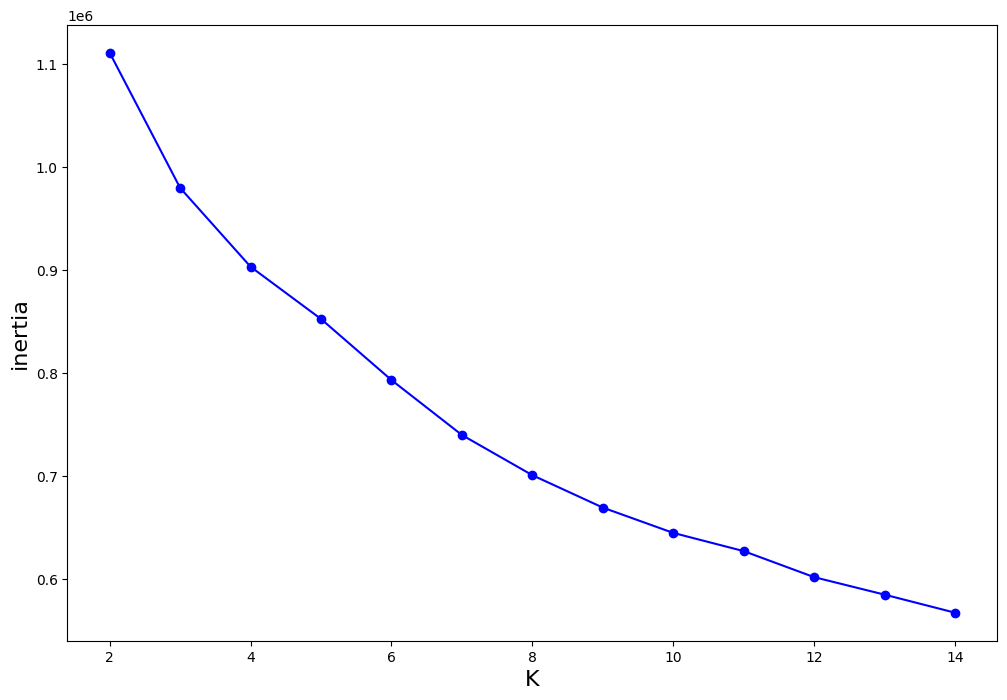

In [17]:
plt.figure(figsize = (12,8))
plt.plot(k_range,inertia,'bo-')
plt.xlabel('K', fontsize = 16)
plt.ylabel('inertia',fontsize = 16)
plt.show()

### Using Silhoutte Score for choosing optimum cluster number
Had to use a sample because its too computation heavy

In [18]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(df_reduced, model.labels_,sample_size=5000, random_state=42)  for model in kmeans_per_k]

In [19]:
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]
# Best number of clusters
best_k

5

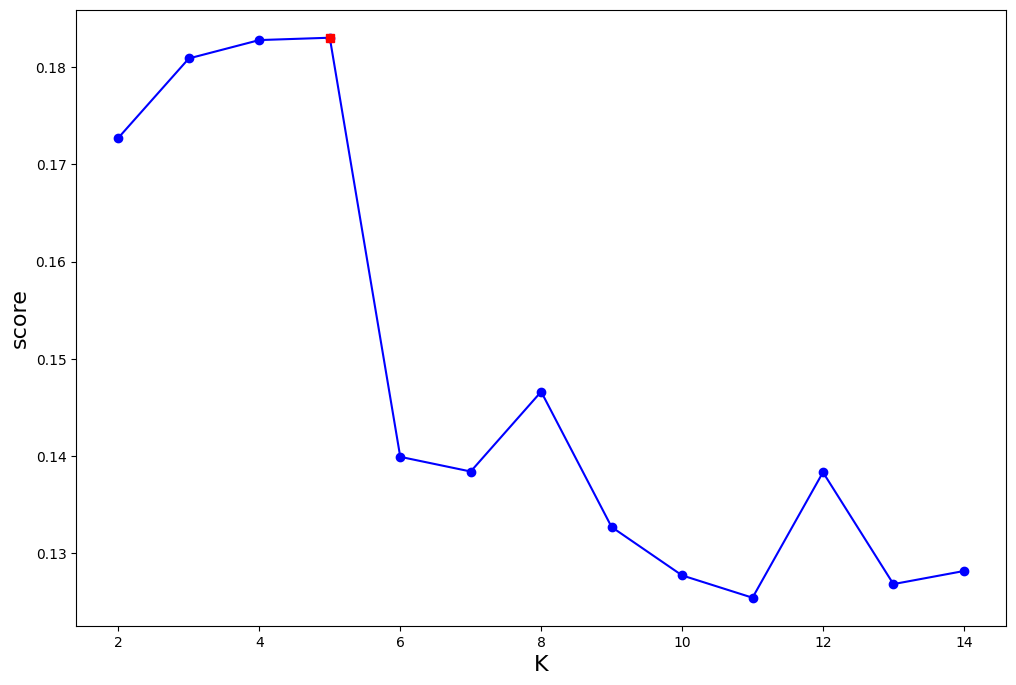

In [20]:
plt.figure(figsize = (12,8))
plt.plot(k_range,silhouette_scores,'bo-')
plt.xlabel('K', fontsize = 16)
plt.ylabel('score',fontsize = 16)
plt.plot(best_k, best_score,'rs')
plt.show()

In [21]:
best_model = kmeans_per_k[best_index]
best_model

KMeans(n_clusters=5, n_init=10, random_state=42)

In [22]:
y_pred = best_model.fit_predict(df_reduced)

In [23]:
for i in range(best_k):
    print(f"cluster {i +1} has {np.sum(y_pred == i)} customers ")

cluster 1 has 42862 customers 
cluster 2 has 51609 customers 
cluster 3 has 16558 customers 
cluster 4 has 2422 customers 
cluster 5 has 4150 customers 


TSNE is very computationally heavy since the data has more than 100k rows

In [24]:
'''from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
df_reduced = tsne.fit_transform(df_reduced) '''

'from sklearn.manifold import TSNE\n\ntsne = TSNE(n_components=2, random_state=42)\ndf_reduced = tsne.fit_transform(df_reduced) '

In [25]:
'''plt.figure(figsize=(13,10 ))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1],c=y_pred, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show() '''

'plt.figure(figsize=(13,10 ))\nplt.scatter(df_reduced[:, 0], df_reduced[:, 1],c=y_pred, cmap="jet")\nplt.axis(\'off\')\nplt.colorbar()\nplt.show() '

In [26]:
df['cluster'] = best_model.labels_

In [27]:
pd.set_option('display.max_columns',None)
df.head(10)

,order_status,customer_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour,cluster
0,delivered,SP,1,29.99,8.72,1,credit_card,1,18.12,2017,10,2,10,0
1,delivered,SP,1,29.99,8.72,3,voucher,1,2.00,2017,10,2,10,0
2,delivered,SP,1,29.99,8.72,2,voucher,1,18.59,2017,10,2,10,0
3,delivered,BA,1,118.70,22.76,1,boleto,1,141.46,2018,7,24,20,1
4,delivered,GO,1,159.90,19.22,1,credit_card,3,179.12,2018,8,8,8,1
5,delivered,RN,1,45.00,27.20,1,credit_card,1,72.20,2017,11,18,19,0
6,delivered,SP,1,19.90,8.72,1,credit_card,1,28.62,2018,2,13,21,1
7,delivered,PR,1,147.90,27.36,1,credit_card,6,175.26,2017,7,9,21,2
8,invoiced,RS,1,49.90,16.05,1,credit_card,1,65.95,2017,4,11,12,0
9,delivered,RJ,1,59.99,15.17,1,credit_card,3,75.16,2017,5,16,13,0


In [28]:
df.shape

(117601, 14)

## Making sense of the clusters, identifying trends to label the clusters

In [29]:
sample_df = df.sample(20000, random_state = 42)
sample_summary = sample_df.groupby('cluster').describe()

Using describe though messy, can give you some idea of the data, look at the important features like price, payment value, frieght value and Ignore the months 

In [30]:
print(sample_summary)

        order_item_id                                                 price  \
                count      mean       std  min  25%  50%  75%   max   count   
cluster                                                                       
0              7318.0  1.085952  0.283223  1.0  1.0  1.0  1.0   3.0  7318.0   
1              8759.0  1.079461  0.270894  1.0  1.0  1.0  1.0   3.0  8759.0   
2              2777.0  1.138999  0.352199  1.0  1.0  1.0  1.0   3.0  2777.0   
3               413.0  1.111380  0.469653  1.0  1.0  1.0  1.0   6.0   413.0   
4               733.0  4.036835  1.815238  2.0  3.0  3.0  4.0  19.0   733.0   

                                                                           \
               mean         std    min      25%     50%      75%      max   
cluster                                                                     
0         88.320678   81.852201   2.29   36.575   59.99   110.00   788.42   
1         89.014522   79.323692   0.85   36.900   67.99   1

In [31]:
numeric_cols = sample_df.select_dtypes(include='number').columns
sample_summary2 = sample_df[numeric_cols].groupby('cluster').mean()

Plotting them together is a bad idea since vary in scale
### Plotting them by important features gives the neseccary information on the clusters

/tmp/ipykernel_13/2251687305.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


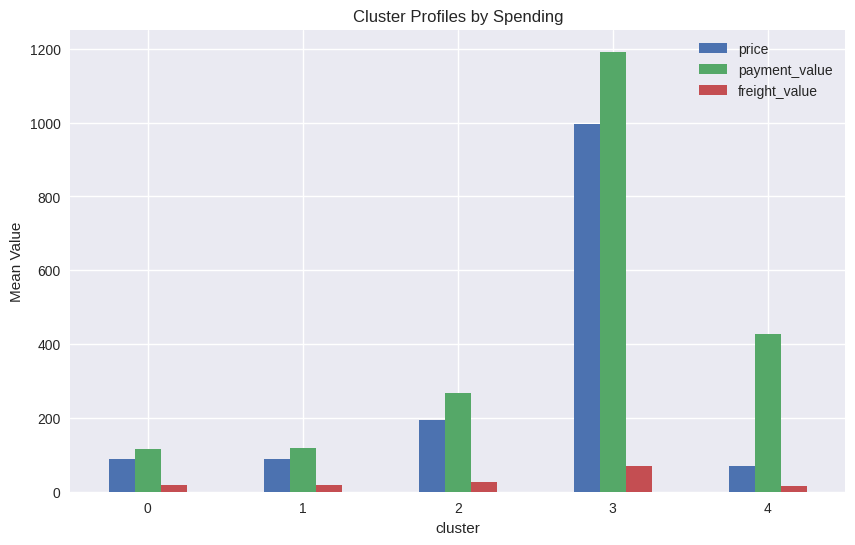

In [32]:
plt.style.use('seaborn')
sample_summary2[['price', 'payment_value', 'freight_value']].plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles by Spending")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.show()

### We can see that cluster 3 customers buy costly products and cluster 4 buy selected products in Bulk. Hence we can categorise cluster 3 as luxury buyers and 4 as bulk buyers

### Also cluster 2, though have bought similar priced items as cluster 0 or 1, they prefer to pay in installments. Hence we categorize them as Installment Buyers. And then we can but cluster 0 and 1 as bargain buyers and causal buyers respectively (Both are almost similar)

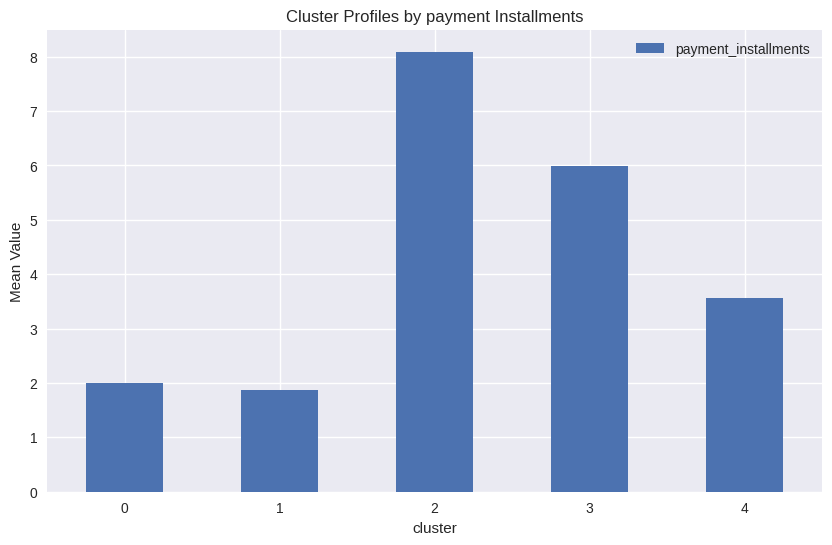

In [33]:
sample_summary2[['payment_installments']].plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles by payment Installments")
plt.ylabel("Mean Value")
plt.xticks(rotation=0)
plt.show()

### Labeling the customers accordingly

In [34]:
label_map = {
    0: 'Bargain Buyers',
    1: 'Casual Buyers',
    2: 'Installment Shoppers',
    3: 'Luxury Buyers',
    4: 'Bulk Buyers'
}

In [35]:
df['segment'] = df['cluster'].map(label_map)

In [36]:
df.head(10)

,order_status,customer_state,order_item_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour,cluster,segment
0,delivered,SP,1,29.99,8.72,1,credit_card,1,18.12,2017,10,2,10,0,Bargain Buyers
1,delivered,SP,1,29.99,8.72,3,voucher,1,2.00,2017,10,2,10,0,Bargain Buyers
2,delivered,SP,1,29.99,8.72,2,voucher,1,18.59,2017,10,2,10,0,Bargain Buyers
3,delivered,BA,1,118.70,22.76,1,boleto,1,141.46,2018,7,24,20,1,Casual Buyers
4,delivered,GO,1,159.90,19.22,1,credit_card,3,179.12,2018,8,8,8,1,Casual Buyers
5,delivered,RN,1,45.00,27.20,1,credit_card,1,72.20,2017,11,18,19,0,Bargain Buyers
6,delivered,SP,1,19.90,8.72,1,credit_card,1,28.62,2018,2,13,21,1,Casual Buyers
7,delivered,PR,1,147.90,27.36,1,credit_card,6,175.26,2017,7,9,21,2,Installment Shoppers
8,invoiced,RS,1,49.90,16.05,1,credit_card,1,65.95,2017,4,11,12,0,Bargain Buyers
9,delivered,RJ,1,59.99,15.17,1,credit_card,3,75.16,2017,5,16,13,0,Bargain Buyers
